# Exercise 3: Model selection


This exercise is a continuation of Exercise 2.1.

Again we have some data in a CSV file (`data.csv`) with columns "x" and "y", and an unknown relationship between the variables.

Question 1 is identical to last week, and you may re-use your solution.

1) Perform curve fits to the data with polynomial functions of degree 1 to 8 and plot the predicted curve against the data points.

A polynomial of degree $n$ with coefficients $\vec{c} = (c_0, ... c_n)$ is simply
$$
f_n(x|\vec{c}) = \sum_{i=0}^n c_i x^i
$$

*Hint:* you can use [polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyfit.html) and [polyval](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyval.html) from NumPy.

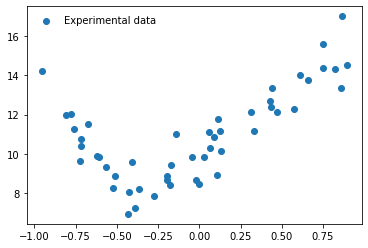

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("data.csv")

from matplotlib import pyplot as plt
plt.scatter(df["x"], df["y"], label = "Experimental data")
x_values = np.linspace(-1, 2.5, 100)
plt.legend(loc='best', frameon=False)
plt.show()


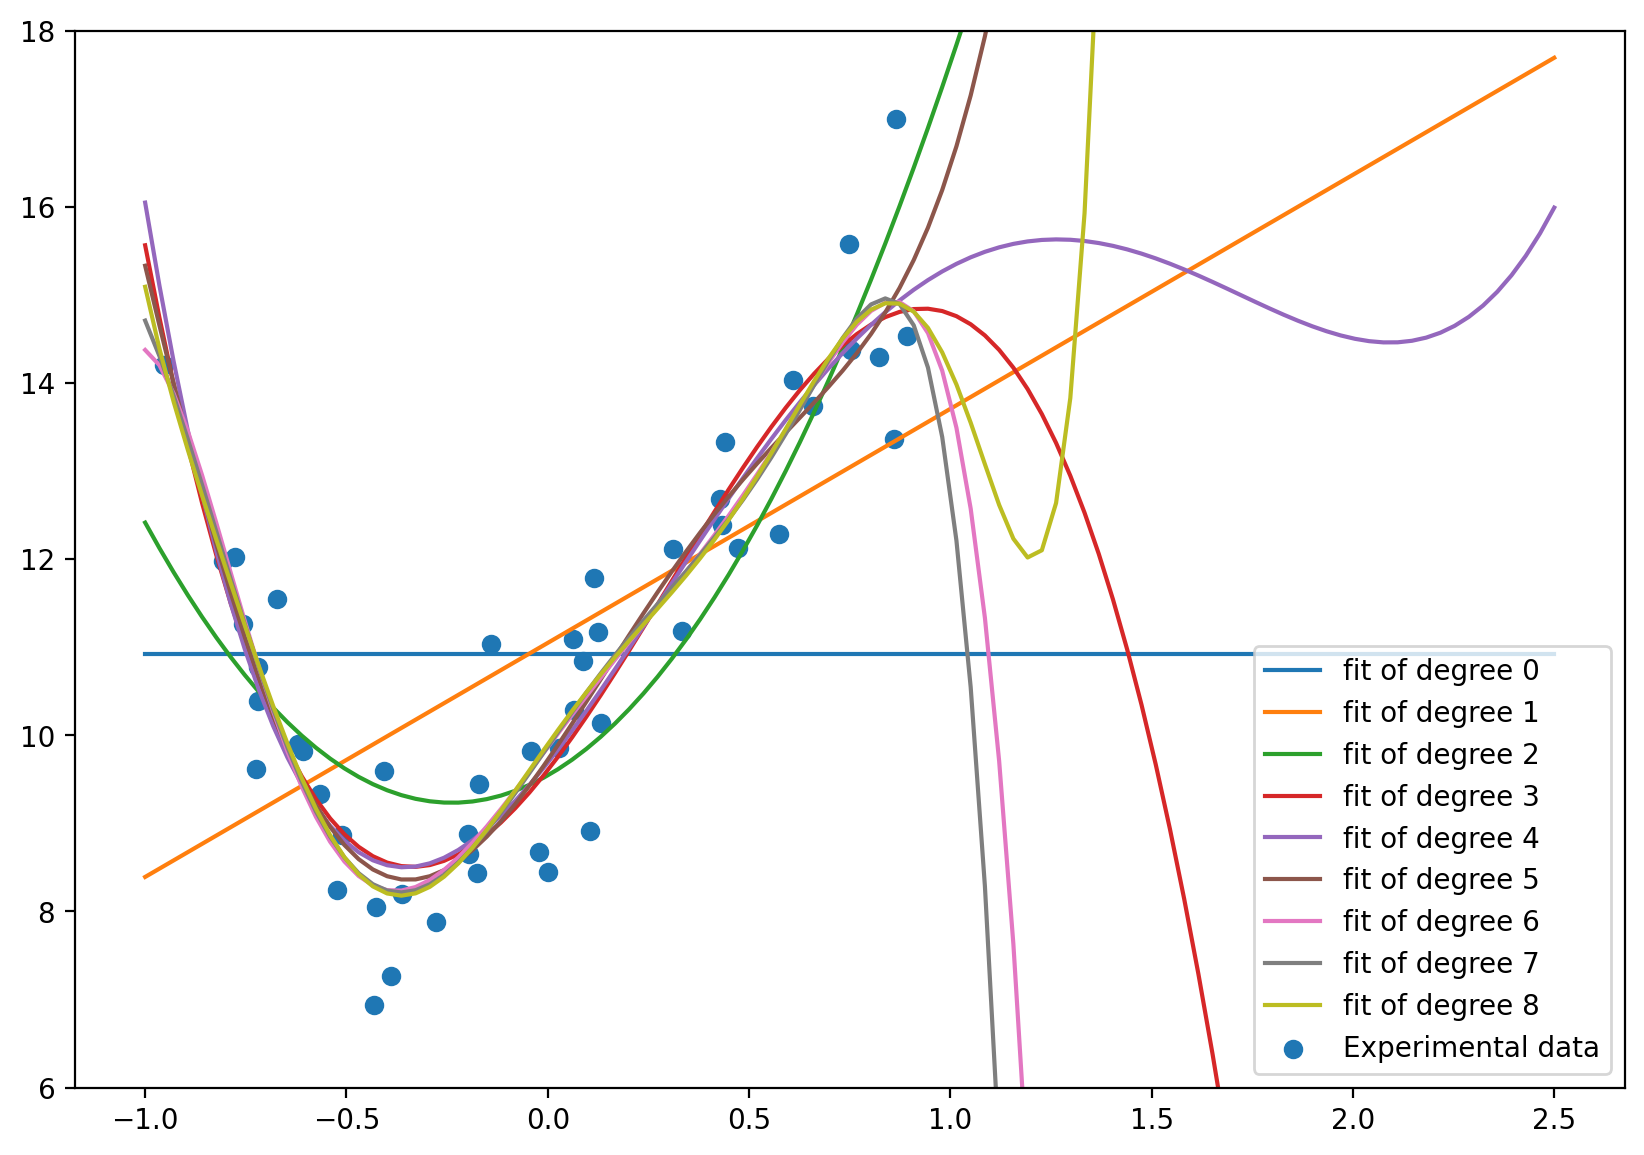

In [22]:

import numpy as np

polynoms = []

plt.figure(figsize=(10,7),dpi=200)

for n in range(0,9):
    pol = np.polynomial.polynomial.polyfit(df["x"],df["y"],n)
    plt.plot(x_values, np.polynomial.polynomial.polyval(x_values, pol), label = f"fit of degree {n}")
    polynoms.append(pol)


plt.ylim((6,18))
plt.scatter(df["x"], df["y"], label = "Experimental data")
plt.legend()
plt.show()

## Information criteria

In the last sheet, we tested the predictive power of the fitted models by taking the average $\chi^2$ evaluated on an ensemble of new datasets generated from the original "true" distribution.

This time we don't have the luxury of knowing the true distribution, so we must quantify the suitability of each model from the data alone.

We can do this using the Bayesian Information Criterion (BIC) and the Akaike Information Criterion (AIC).

In the literature, AIC and BIC are usually defined using $-2 \ln(\mathcal{L})$ as the objective function, where $\mathcal{L}$  is the likelihood. For the sake of this exercise you may use $\chi^2 \approx -2 \ln(\mathcal{L})$ by Wilks' Theorem.

2)

a) Plot AIC, BIC and $\chi^2$ of the fits performed in question 1 as a function of the number of free parameters.

In [84]:
def chiSquare(pol, data):
    return np.mean(np.square(np.subtract(np.polynomial.polynomial.polyval(data["x"],pol) , data["y"]))/ np.square(np.multiply(data["y"], 0.1)))

def BIC(pol, data):
    # print(len(pol))
    return np.mean(np.square(np.subtract(np.polynomial.polynomial.polyval(data["x"],pol) , data["y"]))/ np.square(np.multiply(data["y"], 0.1))) + len(pol) * np.log(len(data["y"]))

def AIC(pol, data):
    return np.mean(np.square(np.subtract(np.polynomial.polynomial.polyval(data["x"],pol) , data["y"]))/ np.square(np.multiply(data["y"], 0.1))) + len(pol) * 2

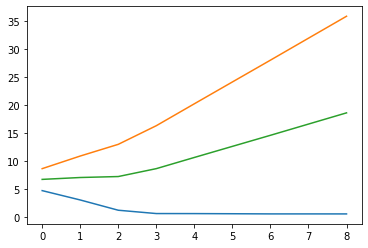

In [85]:
chi2 = []
BICs = []
AICs = []

for pol in polynoms:
    chi2.append(chiSquare(pol,df))
    BICs.append(BIC(pol,df))
    AICs.append(AIC(pol,df))

import matplotlib.pyplot as plt

plt.plot(chi2)
plt.plot(BICs)
plt.plot(AICs)


Be prepared to discuss the following questions with your tutor. You can use the cell below to prepare your answers.

b) How are the information criteria more useful than just picking the model that gives the best $\chi^2$?

c) How do AIC and BIC differ from one another qualitatively? In which situations would one be more appropriate than the other?

d) Which degree of polynomial would you choose as the best model of the data?

## Cross validation

In the classification exercise (2.2) we explored the idea of using part of the dataset for validation (by splitting into "training" and "testing" samples). Cross-validation takes this concept further by repeating the procedure with different sub-sets of the data and taking the average result.

In **leave-one-out cross validation (LOOCV)**, only a single datapoint at a time is used for validation, while the remaining $n-1$ are used to train the model. This is repeated $n$ times so that each datapoint has been used for validation. The mean value of $\chi^2$ is then used to evaluate the model: 

$$
\overline{\chi^2} = \frac{1}{n}\sum_{i=1}^{n} \chi^2_{i}
$$

3)

a) Perform LOOCV for this dataset and plot the value of $\overline{\chi^2}$ as a function of number of free parameters

In [38]:
dataChunks = np.array_split(df,4)
dataChunks[3]
dataChunks = np.array_split(df,len(df["y"]))
dataChunks[4]

chiSquare(polynoms[2],dataChunks[2])

def kFold(polDeg,data,k):
    dataChunks = np.array_split(data,k)
    chi2s = []
    for chunk in dataChunks:
        complementData = df.drop(chunk.index)
        pol = np.polynomial.polynomial.polyfit(complementData["x"],complementData["y"],polDeg)
        chi2 = chiSquare(pol,chunk)
        chi2s.append(chi2)
    return np.mean(chi2s)

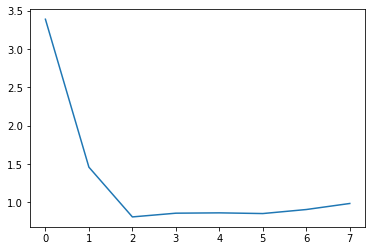

In [88]:
chis = []

for n in range(1,9):
    chis.append(kFold(n,df,len(df["y"])))

plt.plot(chis)

In **$k$-fold cross validation**, the data is divided evenly into $k$ groups, one of which is used for validation, while the others are used to train the model. Again, this is repeated $k$ times until all have been used for validation, and the model is evaluated with the mean value of $\chi^2$:

$$
\overline{\chi^2} = \frac{1}{k}\sum_{i=1}^{k} \chi^2_{i}
$$

b) perform $k$-fold cross validation for this dataset using $k=3,4,5$ and plot the value of $\overline{\chi^2}$ as a function of number of free parameters.

Some more discussion questions:

c) What are the advantages and disadvantages of LOOCV versus using a single validation set?

d) How does $k$-fold cross perform compared to LOOCV?

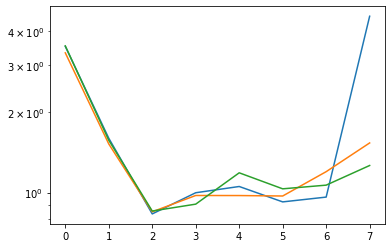

In [87]:
chis = []
for k in [3,4,5]:
    for n in range(1,9):
        chis.append(kFold(n,df,k))

chis = np.reshape(chis,(3,8))

for chi in chis:
    plt.plot(chi)

plt.yscale("log")